In [4]:
import pickle 
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')
#hits median = 330
#hits max = 134650
#hits min = 0


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/sean/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [5]:
work_df = pd.read_pickle('work_df.pkl')

In [15]:
X = work_df.drop(columns = ['warnings', 'ratings', 'num_ratings', 'fandoms', 'relationships', 'characters', 'freeforms', 'language', 'comments', 'kudos', 'bookmarks', 'sentiment_scores', 'hits', 'work_id', 'chapters']).astype(float)
y = work_df['hits']

In [ ]:
# Code taken from Metis

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv = cross_val_score(lm, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv), 3), "+-", np.round(np.std(lm_cv),3))

Simple regression scores:  [ 0.30600188  0.14240945  0.52619196  0.27562332 -0.52765754]
Simple mean cv r^2:  0.145 +- 0.358


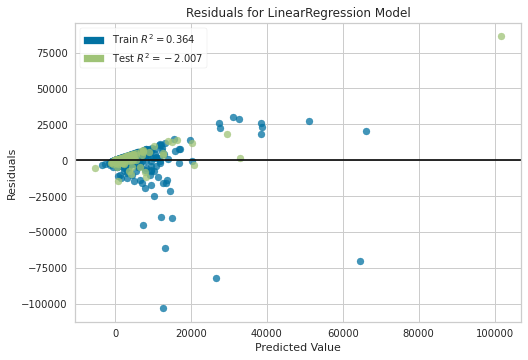

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [17]:
import yellowbrick
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lm, hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

In [19]:
y_pred = lm.predict(X_test)
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
print(rmse, mse)

6999.165357120866 48988315.69632087


From our baseline model, we see that our average R^2 is .14, with one of the folds even producing a negative R^2. Let's see if we can improve it at all. First, let's look at how our target is distributed.

Text(0, 0.5, 'Works')

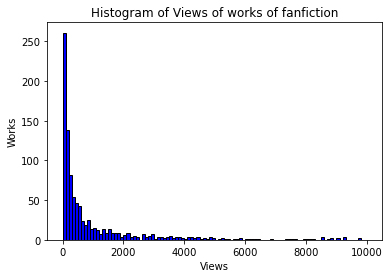

In [12]:
plt.hist(work_df['hits'], range=[0, 10000], color = 'blue', edgecolor = 'black', bins=100)

plt.title('Histogram of Views of works of fanfiction')
plt.xlabel('Views')
plt.ylabel('Works')

And let's look at a heatmap as well:

<AxesSubplot:>

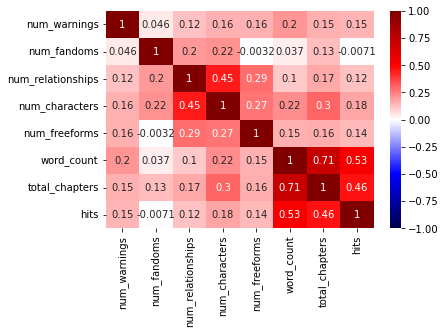

In [18]:
X['hits'] = work_df['hits']
sns.heatmap(X.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)

Our target, 'hits' seems to be weekly correlated with all our features except for word count and total chapters. However, these are also highly correlated with each other which might give us trouble. Let's look at the vif for our features:

In [21]:
X = work_df.drop(columns = ['warnings', 'ratings', 'num_ratings', 'fandoms', 'relationships', 'characters', 'freeforms', 'language', 'comments', 'kudos', 'bookmarks', 'sentiment_scores', 'hits', 'work_id', 'chapters']).astype(float)
y = work_df['hits']
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = sm.add_constant(X) 
model = sm.OLS(y, X)
fit = model.fit()

vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

/home/sean/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,variables,vif
0,const,10.282181
1,num_warnings,1.071774
2,num_fandoms,1.084427
3,num_relationships,1.329528
4,num_characters,1.400044
5,num_freeforms,1.152720
6,word_count,2.104773
7,total_chapters,2.164511


None of them have a vif over 5, which is good. It means we likely don't need to eliminate them. However, if we look at the summary...

In [22]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hits   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     61.63
Date:                Wed, 15 Jun 2022   Prob (F-statistic):           1.33e-73
Time:                        01:23:25   Log-Likelihood:                -10324.
No. Observations:                1002   AIC:                         2.066e+04
Df Residuals:                     994   BIC:                         2.070e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -335.9762    734.507     -0.457      0.647   -1777.338    1105.385
num_warnings        657.0148    541.173      1.214      0.225    -404.957    1718.987
num_fandoms        -480.8498    233.285     -2.061      0.040    -938.638     -23.061
num_relationships   130.3110     99.748      1.306      0.192     -65.429     326.051
num_characters       27.8019     43.932      0.633      0.527     -58.408     114.011
num_freeforms        24.4532     25.387      0.963      0.336     -25.364      74.271
word_count            0.0673      0.007     10.140      0.000       0.054       0.080
total_chapters       89.6495     20.463      4.381      0.000      49.494     129.805
==============================================================================
Omnibus:                     1403.095   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           428530.146
Skew:                           7.608   Prob(JB):                         0.00
Kurtosis:                     103.163   Cond. No.                     2.02e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Many of our features are not statistically significant. Let's try eliminating a few...

In [25]:
X.drop(columns=['num_characters', 'num_freeforms', 'const'], inplace=True)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_2 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_2 = cross_val_score(lm_2, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_2)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_2), 3), "+-", np.round(np.std(lm_cv_2),3))

Simple regression scores:  [ 0.33554716  0.14313091  0.5317253   0.27626263 -0.52800914]
Simple mean cv r^2:  0.152 +- 0.362


Okay, our average score went up, which means we probably don't need those features. Let's see if we can drop some more.

In [27]:
X.drop(columns=['num_warnings', 'num_relationships'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_3 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_3 = cross_val_score(lm_3, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_3)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_3), 3), "+-", np.round(np.std(lm_cv_3),3))

Simple regression scores:  [ 0.32416774  0.14703722  0.53145642  0.31986065 -0.51709422]
Simple mean cv r^2:  0.161 +- 0.36


Okay, our average R^2 got even better when eliminating those features. Should we keep dropping? Let's see the vif again:

In [28]:
vif = pd.DataFrame()
vif['variables'] = X.columns
vif['vif'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,vif
0,num_fandoms,1.206175
1,word_count,2.332792
2,total_chapters,2.543436


Still low vif. Let's see the model summary:

In [29]:
X = sm.add_constant(X) 
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

/home/sean/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hits   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     140.6
Date:                Wed, 15 Jun 2022   Prob (F-statistic):           5.79e-76
Time:                        01:55:25   Log-Likelihood:                -10328.
No. Observations:                1002   AIC:                         2.066e+04
Df Residuals:                     998   BIC:                         2.068e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            936.5977    402.305      2.328      0.020     147.137    1726.058
num_fandoms     -383.7012    227.033     -1.690      0.091    -829.218      61.816
word_count         0.0688      0.007     10.467      0.000       0.056       0.082
total_chapters    97.2765     20.136      4.831      0.000      57.764     136.789
==============================================================================
Omnibus:                     1395.586   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           417668.270
Skew:                           7.536   Prob(JB):                         0.00
Kurtosis:                     101.878   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's see what happens if we drop num_fandoms. It doesn't look like it's statistically significant.

In [30]:
X.drop(columns=['num_fandoms', 'const'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_4 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_4 = cross_val_score(lm_4, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_4)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_4), 3), "+-", np.round(np.std(lm_cv_4),3))

Simple regression scores:  [ 0.32013489  0.1464228   0.53050046  0.32073409 -0.52972946]
Simple mean cv r^2:  0.158 +- 0.365


Not much difference, so I think we can drop it. Maybe we should drop either word count or total chapters as well. They're highly correlated with each other, which might be where the multicollinearity is causing a problem. Let's see what happens:

In [31]:
X.drop(columns=['total_chapters'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_5 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_5 = cross_val_score(lm_5, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_5)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_5), 3), "+-", np.round(np.std(lm_cv_5),3))

Simple regression scores:  [ 0.31289289  0.14560485  0.53960676  0.30497132 -0.5857002 ]
Simple mean cv r^2:  0.143 +- 0.386


Our R^2 dipped by a little there, so maybe we should add it back in, and drop word_count instead. Let's try:

In [33]:
X['total_chapters'] = work_df['total_chapters']
#X.drop(columns=['word_count'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_6 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_6 = cross_val_score(lm_6, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_6)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_6), 3), "+-", np.round(np.std(lm_cv_6),3))

Simple regression scores:  [ 0.27330093 -0.00414456  0.32835647  0.19896538 -0.34155897]
Simple mean cv r^2:  0.091 +- 0.244


Ok, eliminating word count accounted for a fairly signicant dip. Let's keep both in, and try multiplying those two for an additional term.

In [35]:
X['word_count'] = work_df['word_count']
X['word_count*total_chapters'] = X['word_count'].astype(float)*X['total_chapters'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_7 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_7 = cross_val_score(lm_7, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_7)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_7), 3), "+-", np.round(np.std(lm_cv_7),3))

Simple regression scores:  [ 0.32482478  0.14910951  0.14143138  0.32095251 -0.69914024]
Simple mean cv r^2:  0.047 +- 0.382


Abject failure. Let's square a term instead, like word count. 

In [39]:
X.drop(columns=['word_count*total_chapters'], inplace=True)
X['word_count^2'] = X['word_count'].astype(float) * X['word_count'].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_8 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_8 = cross_val_score(lm_8, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_8)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_8), 3), "+-", np.round(np.std(lm_cv_8),3))

Simple regression scores:  [ 0.31369091  0.13524022  0.06421141  0.2722748  -0.55606423]
Simple mean cv r^2:  0.046 +- 0.314


No good, let me try a log transformation of the target:

In [43]:
X.drop(columns=['word_count^-1'], inplace=True)
y = np.log(work_df['hits'])

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_9 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_9 = cross_val_score(lm_9, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_9)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_9), 3), "+-", np.round(np.std(lm_cv_9),3))

Simple regression scores:  [nan nan nan nan nan]
Simple mean cv r^2:  nan +- nan


/home/sean/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sean/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/sean/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sean/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "/home/sean/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/sean/anaconda3/lib/python3.9/site-packages/sklearn/u

Failed for some reason, not sure why. Let's add in sentiment scores, gotten from using the Sentiment Intensity Analyzer from nltk's vader on the actual text of each work. We'll use the compound scores. 

In [22]:
X['compound_score'] = work_df['sentiment_scores'].apply(lambda x: x['compound'])


In [20]:
X.drop(columns=['num_warnings', 'num_fandoms', 'num_relationships', 'num_characters', 'num_freeforms'], inplace=True)

In [30]:
y = work_df['hits']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_10 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_10 = cross_val_score(lm_10, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_10)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_10), 3), "+-", np.round(np.std(lm_cv_10),3))

Simple regression scores:  [ 0.3216032   0.14832465  0.52483192  0.31990453 -0.51676624]
Simple mean cv r^2:  0.16 +- 0.359


/home/sean/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


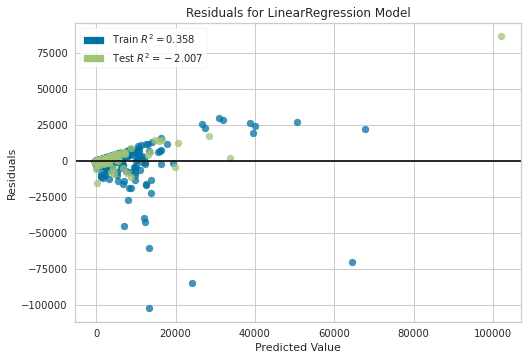

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [14]:
import yellowbrick
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(lm_10, hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()               

In [31]:
y_pred = lm_10.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)
print(rmse, mse)

NotFittedError: This LinearRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

A slight improvement. Let's see if we can improve that by adding in some dummy variables for the ratings.

In [29]:
ratings_dummies = pd.get_dummies(work_df['ratings'])


Our default category is "Not Rated." The other ratings are Teen And Up Audiences, Mature, Explicit, and General Audiences.



In [79]:
ratings_dummies.drop(columns='Not Rated', inplace=True)


In [81]:
X = pd.concat([X, ratings_dummies], axis=1)

In [83]:


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_11 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_11 = cross_val_score(lm_11, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_11)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_11), 3), "+-", np.round(np.std(lm_cv_11),3))

Simple regression scores:  [ 0.31252162  0.14586226  0.51531494  0.32849564 -0.5168972 ]
Simple mean cv r^2:  0.157 +- 0.357


It got a little worse. Are any of them significant?

In [91]:

model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   hits   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     61.09
Date:                Wed, 15 Jun 2022   Prob (F-statistic):           4.89e-73
Time:                        03:07:01   Log-Likelihood:                -10326.
No. Observations:                1002   AIC:                         2.067e+04
Df Residuals:                     994   BIC:                         2.071e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -337.6508    716.158     -0.471      0.637   -1743.005    1067.704
word_count                0.0686      0.007     10.450      0.000       0.056       0.082
total_chapters           93.9049     20.063      4.681      0.000      54.535     133.275
compound_score          336.5876    276.054      1.219      0.223    -205.127     878.303
Explicit               1585.0114    875.540      1.810      0.071    -133.107    3303.130
General Audiences       198.7620    887.159      0.224      0.823   -1542.158    1939.682
Mature                 1006.6173    869.286      1.158      0.247    -699.228    2712.463
Teen And Up Audiences   214.9638    830.140      0.259      0.796   -1414.065    1843.992
==============================================================================
Omnibus:                     1399.217   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414362.153
Skew:                           7.581   Prob(JB):                         0.00
Kurtosis:                     101.463   Cond. No.                     3.85e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Maybe the explicit category just on it's own, so just reduce it to a Explicit and Not Explicit category.

In [93]:
X.drop(columns=['General Audiences', 'Mature', 'Teen And Up Audiences', 'const'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_11 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_11 = cross_val_score(lm_11, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_11)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_11), 3), "+-", np.round(np.std(lm_cv_11),3))

Simple regression scores:  [ 0.30997155  0.14817947  0.51649036  0.32555358 -0.51584451]
Simple mean cv r^2:  0.157 +- 0.356


Just about the same. Let's eliminate these dummies, and try the ones for warnings.

In [94]:
# A function to help me make the warning dummies
def warning_dummies(a_list, warning):
    if warning in a_list:
        return 1
    else:
        return 0

In [95]:
X.drop(columns=['Explicit'], inplace=True)
X['none_apply'] = work_df['warnings'].apply(lambda x: warning_dummies(x, 'No Archive Warnings Apply'))
X['creator_chose_none'] = work_df['warnings'].apply(lambda x: warning_dummies(x, 'Creator Chose Not To Use Archive Warnings'))
X['graphic_violence'] = work_df['warnings'].apply(lambda x: warning_dummies(x, 'Graphic Depictions Of Violence'))
X['character_death'] = work_df['warnings'].apply(lambda x: warning_dummies(x, 'Major Character Death'))
X['coercion'] = work_df['warnings'].apply(lambda x: warning_dummies(x, 'Rape/Non-Con'))
X['underage'] = work_df['warnings'].apply(lambda x: warning_dummies(x, 'Underage'))

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=.2,     
                                       random_state=42)
lm_12 = LinearRegression() 

kf = KFold(n_splits=5, # number of folds
     shuffle=True, # randomizes order of rows before split
     random_state = 42) # using same number in future code/ rerunning allows us to replicate the split 

#to see all validation scores
lm_cv_12 = cross_val_score(lm_12, X_train, y_train, # estimator, features, target
     cv= kf, # folds created above; could also just use a number 
     scoring='r2') # scoring metric
print('Simple regression scores: ', lm_cv_12)

# to print the mean score with standard deviation, rounded to 2 decimals
print('Simple mean cv r^2: ', np.round(np.mean(lm_cv_12), 3), "+-", np.round(np.std(lm_cv_12),3))

Simple regression scores:  [ 0.35037156  0.17145769  0.51884953  0.23987189 -0.7667031 ]
Simple mean cv r^2:  0.103 +- 0.45


Decreased again, so I think it's time to accept that the only useful features are word_count and total chapters. 